2.1) Socket Programming with Data Buffering.

The code below gets the data from the sensor logger app using a socket server. I used a buffer for batch processing of the data which is to be parsed and exported. The data is parsed into a csv file.

In [150]:
import dash
from dash.dependencies import Output, Input
from dash import dcc, html, dcc
from datetime import datetime
import json
import plotly.graph_objs as go
from collections import deque
from flask import Flask, request
import csv
import numpy as np

server = Flask(__name__)
app = dash.Dash(__name__, server=server)

MAX_DATA_POINTS = 1000
UPDATE_FREQ_MS = 100

buffer= []
accMat= np.array([1,2,3])

norm= np.array([1,2,3])

totalaccMat= np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

# Create a CSV file for storing sensor data
csv_filename = "sensor_data.csv"

with open(csv_filename, "w", newline="") as csv_file:
    fieldnames = ["Sensor", "Timestamp", "X", "Y", "Z"]  # Define CSV column names
    csv_writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    csv_writer.writeheader()  # Write the header row


time = deque(maxlen=MAX_DATA_POINTS)
sensor_name= deque(maxlen= MAX_DATA_POINTS)
accel_x = deque(maxlen=MAX_DATA_POINTS)
accel_y = deque(maxlen=MAX_DATA_POINTS)
accel_z = deque(maxlen=MAX_DATA_POINTS)

app.layout = html.Div(
	[
		dcc.Markdown(
			children="""
			# Live Sensor Readings
			Streamed from Sensor Logger: tszheichoi.com/sensorlogger
		"""
		),
		dcc.Graph(id="live_graph"),
		dcc.Interval(id="counter", interval=UPDATE_FREQ_MS),
	]
)


@app.callback(Output("live_graph", "figure"), Input("counter", "n_intervals"))
def update_graph(_counter):
	data = [
		go.Scatter(x=list(time), y=list(d), name=name)
		for d, name in zip([accel_x, accel_y, accel_z], ["X", "Y", "Z"])
	]

	graph = {
		"data": data,
		"layout": go.Layout(
			{
				"xaxis": {"type": "date"},
				"yaxis": {"title": "Acceleration ms<sup>-2</sup>"},
			}
		),
	}
	if (
		len(time) > 0
	):  # Â cannot adjust plot ranges until there is at least one data point
		graph["layout"]["xaxis"]["range"] = [min(time), max(time)]
		graph["layout"]["yaxis"]["range"] = [
			min(accel_x + accel_y + accel_z),
			max(accel_x + accel_y + accel_z),
		]

	return graph

def csvMaker(filename, buf):
     with open(filename,mode = 'a+', newline='') as csv_file:
          csv_writer = csv.writer(csv_file)
          for row in buf:
               sensor= row[0]
               timestamp= row[1]
               x= row[2]
               y= row[3]
               z= row[4]
               csv_writer.writerow([sensor,timestamp,x,y,z])


@server.route("/data", methods=["POST"])
def data():
    global accMat, totalaccMat, norm
    if str(request.method) == "POST":
        data = json.loads(request.data)
        for d in data['payload']:
            sensor= d.get("name", None)
            timestamp= datetime.fromtimestamp(d["time"] / 1000000000)
            xVal= (d["values"]["x"])
            yVal= (d["values"]["y"])
            zVal= (d["values"]["z"])
            row = [sensor, str(timestamp), str(xVal), str(yVal), str(zVal)]
            buffer.append(row)
            aRow= [xVal, yVal, zVal]
            accMat= np.vstack((accMat, aRow))
            norm= np.vstack((norm, aRow))
            if(len(buffer)==5):
                 csvMaker(csv_filename, buffer)
                 buffer.clear()
                 aMat= accMat[1:]
                 sampleARow= aMat.flatten()
                 totalaccMat= np.vstack((totalaccMat,sampleARow))
                 accMat= accMat[0]
            
            if d.get("name", None) == "accelerometer" or d.get("name", None) == "gravity":
                ts = datetime.fromtimestamp(d["time"] / 1000000000)
                if len(time) == 0 or ts > time[-1]:
                    time.append(ts)
                    accel_x.append(d["values"]["x"])
                    accel_y.append(d["values"]["y"])
                    accel_z.append(d["values"]["z"])
                    sensor_name.append(d.get("name", None))  # Proper indentation here

    return "success"



if __name__ == "__main__":
	app.run_server(port=8000, host="172.31.193.134")

Part 2.2) PCA with covariance matrix.

1)The code below uses the numpy library to calculate the covariance data of the sensor data.

In [151]:
import numpy as np

def covarianceCalculate():
    totalAMat= totalaccMat[1:]
    totalAMat= totalAMat.T
    cov= np.cov(totalAMat)
    return cov, totalAMat, norm

cov= covarianceCalculate()

2)The code below uses sklearn to do Principle Component Analysis(PCA). First it standardizes the data and runs the fit_transofrm method on the standardized data to return the pca_features matrix. It also returns the explained variance ratio for the pca features.

In [152]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def PCAFunction():
    scaler= StandardScaler()
    std= scaler.fit_transform(totalaccMat)
    pca= PCA(n_components=2)
    pca_features= pca.fit_transform(std)
    explained_ratio= pca.explained_variance_ratio_
    
    return pca_features, explained_ratio

pca_feat, explained_rat= PCAFunction()
pca_feat.shape
    


(81, 2)

3)The code below gets the pca_features of a sensor recording data and visualizes it onto a lower dimensional space.

[0.53109284 0.19984808]


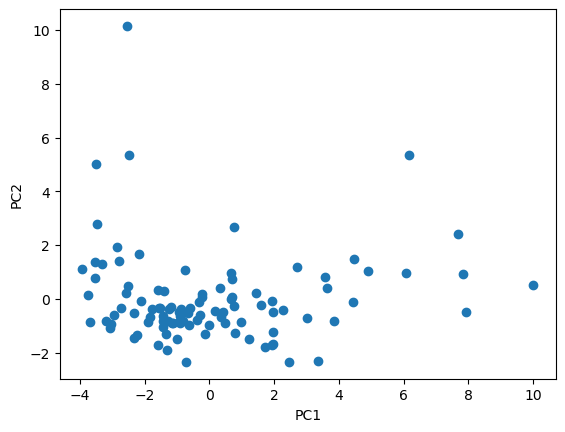

In [149]:
import matplotlib.pyplot as plt
cov, accMat, normalArr= covarianceCalculate()
normalArr= normalArr[1:]
pca_features, explained_ratio= PCAFunction()

print(explained_ratio)

plt.scatter(pca_features[:,0], pca_features[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


The code below is the same as the code above but uses new variables to store the data of a different recording.

[0.47775693 0.19863499]


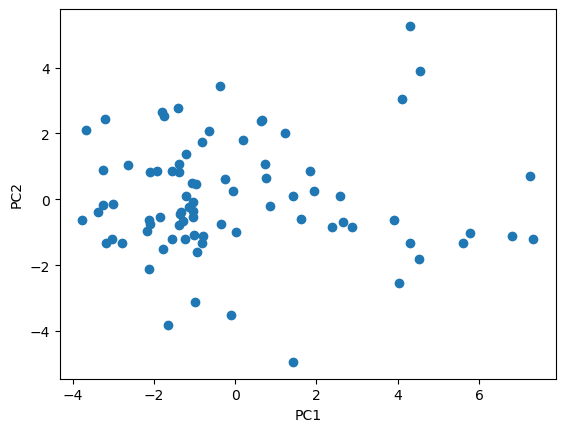

In [153]:
import matplotlib.pyplot as plt
cov2, accMat2, normalArr2= covarianceCalculate()
normalArr2= normalArr2[1:]
pca_features2, explained_ratio2= PCAFunction()

print(explained_ratio2)

plt.scatter(pca_features2[:,0], pca_features2[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()



Principal Component Analysis was performed on 2 separate recordings above and the explained variance ratios were printed out. As you can see in the output for the first recording above, the variance explained by the first principal component is about 55% and the variance explained by the second principal component is about 23%. For the second recording, the variance explained by the first principal component is about 62% and the variance explained by the second principal component is about 22%. 

Part2.3) Dynamic Time Warping (with attempted early abandoning).

1)The code below defines a dtw_function which does dynamic time warping on specific dimensions. It compares the x-values, y-values and z-values from 2 separate recordings. The function also finds the dtw distances for each dimension. The DTW is used for the purpose of finding the similarity between two time sequences in the same dimension which may vary.

In [154]:
from dtw import *
import numpy as np

def dtw_function(x_arr1, x_arr2, y_arr1, y_arr2, z_arr1, z_arr2):
    x_dtw= dtw(x_arr1, x_arr2, keep_internals= True)
    x_dtw.plot(type="twoway")
    y_dtw= dtw(y_arr1, y_arr2, keep_internals= True)
    y_dtw.plot(type="twoway")
    z_dtw= dtw(z_arr1, z_arr2, keep_internals= True)
    z_dtw.plot(type="twoway")

     # Get the alignment path as a list of pairs of indices
    x_alignment_path = list(zip(x_dtw.index1, x_dtw.index2))
    y_alignment_path = list(zip(y_dtw.index1, y_dtw.index2))
    z_alignment_path = list(zip(z_dtw.index1, z_dtw.index2))

    # Calculate distances between corresponding points
    x_distances = [abs(x_arr1[i] - x_arr2[j]) for i, j in x_alignment_path]
    y_distances = [abs(y_arr1[i] - y_arr2[j]) for i, j in y_alignment_path]
    z_distances = [abs(z_arr1[i] - z_arr2[j]) for i, j in z_alignment_path]

    return x_distances, y_distances, z_distances



2)The below code block runs the dtw_function on all dimensions from 2 different recordings.

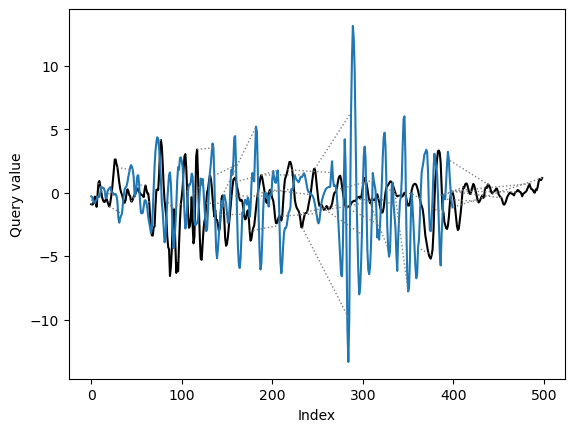

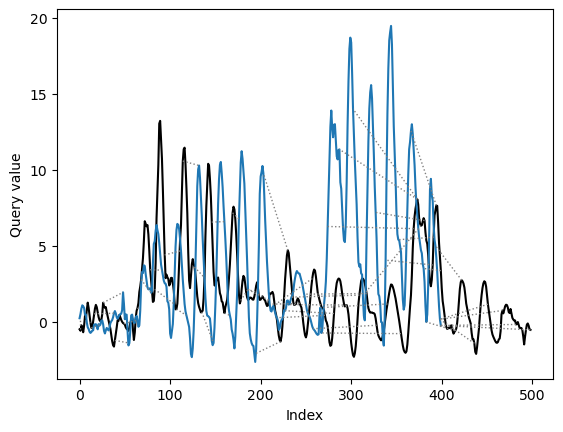

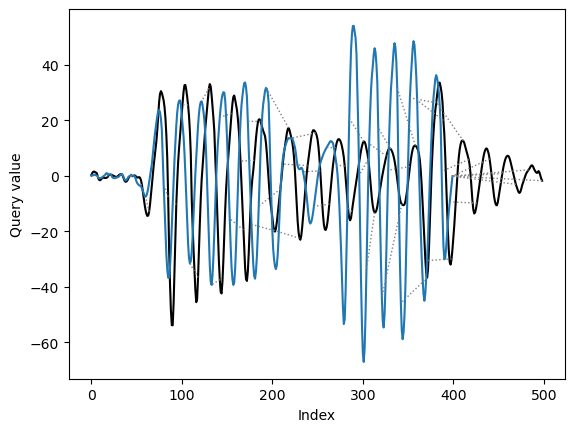

In [155]:
x_arr1= normalArr[:,0]
x_arr2= normalArr2[:,0]

y_arr1= normalArr[:,1]
y_arr2= normalArr2[:,1]

z_arr1= normalArr[:,2]
z_arr2= normalArr2[:,2]

x_dtw_distance, y_dtw_distance, z_dtw_distance= dtw_function(x_arr1, x_arr2, y_arr1, y_arr2, z_arr1, z_arr2)


Part 2.4) Anomaly Detection.
In this part, I used sklearn and OneClassSVM to do anomoly detection using a one class svm model.

The libraries used are imported below.

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM


1)The code below splits the data into training data and testing data from the pca features matrix which was found in part 2.2. 

In [157]:
acc_train, acc_test= train_test_split(pca_features2, test_size=0.2, random_state=42)
print(acc_train.shape[0])
print(acc_test.shape[0])

one_class_svm= OneClassSVM(nu=0.05, kernel = 'rbf', gamma= 'auto').fit(acc_train)
score= one_class_svm.score_samples(acc_test)
score_threshold= np.percentile(score,2)

prediction= [1 if i<score_threshold else 0 for i in score]



64
17


The code below visualizes the anomaly detection model.

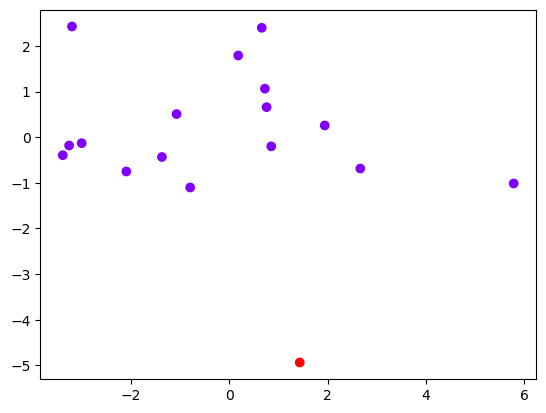

In [158]:
df_test= pd.DataFrame(acc_test, columns=['feat1', 'feat2'])
df_test['anomoly detection']= prediction

plt.scatter(df_test['feat1'], df_test['feat2'], c=df_test['anomoly detection'], cmap='rainbow')

The code below runs anomaly detection on the second recording.

80
20


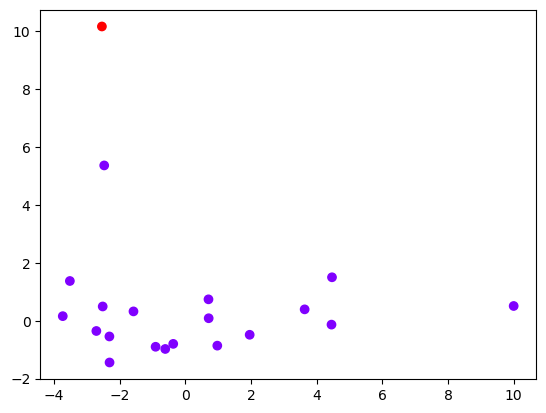

In [159]:
acc_train, acc_test= train_test_split(pca_features, test_size=0.2, random_state=42)
print(acc_train.shape[0])
print(acc_test.shape[0])

one_class_svm= OneClassSVM(nu=0.05, kernel = 'rbf', gamma= 'auto').fit(acc_train)
score= one_class_svm.score_samples(acc_test)
score_threshold= np.percentile(score,2)

prediction= [1 if i<score_threshold else 0 for i in score]
df_test= pd.DataFrame(acc_test, columns=['feat1', 'feat2'])
df_test['anomoly detection']= prediction

plt.scatter(df_test['feat1'], df_test['feat2'], c=df_test['anomoly detection'], cmap='rainbow')

2) An attempt on using DTW distances between timeseries as features and improving the anomaly detection model. As mentioned above, the dtw_function which was implemented returns the lists of distances between each pair of corresponding points in the time series data for the X,Y and Z dimensions. The 3 variables x_dtw_distance, y-dtw_distance and z_dtw_distance, hold the dtw distances. In this code below, dtw_distances are included as features in the anomaly detection model. The DTW distances are combined into one matrix, and the One-Class SVM model is trained on this combined dataset. This approach allows the model to leverage both the PCA features and the DTW distances for improved anomaly detection.

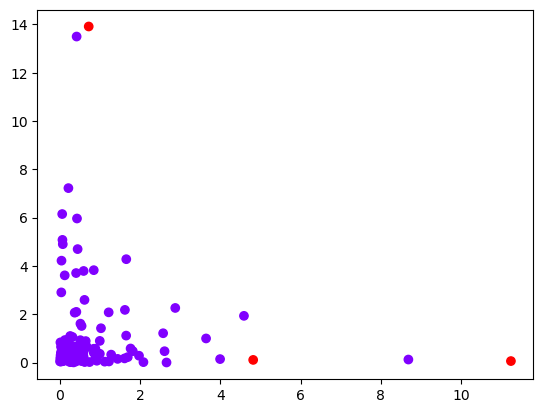

In [160]:
min_len= min(len(x_dtw_distance), len(y_dtw_distance), len(z_dtw_distance))
x_dtw_distance= x_dtw_distance[0:min_len]
y_dtw_distance= y_dtw_distance[0:min_len]
z_dtw_distance= z_dtw_distance[0:min_len]

dist_mat= np.array((x_dtw_distance, y_dtw_distance, z_dtw_distance), dtype=float)
dist_mat= dist_mat.T
acc_train, acc_test = train_test_split(dist_mat, test_size=0.2, random_state=42)


one_class_svm = OneClassSVM(nu=0.05, kernel='rbf', gamma='auto').fit(acc_train)

score = one_class_svm.score_samples(acc_test)

score_threshold = np.percentile(score, 2)
prediction= [1 if i<score_threshold else 0 for i in score]
df_test= pd.DataFrame(acc_test, columns=['feat1', 'feat2', 'feat3'])
df_test['anomoly detection']= prediction

plt.scatter(df_test['feat1'], df_test['feat2'], c=df_test['anomoly detection'], cmap='rainbow')


The plot above shows multiple anomalies with this improved anomaly detection model. Since this is only a 2D plot, the anomalies shown within the cluster may have obscure values in the Z dimension.